<a href="https://colab.research.google.com/github/JoannaLe/cancer-detection/blob/master/cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMS 4995 Final Project
Joanna Le (jl4624) \\
Ashley Koo (hk2827)

The aim of this project is to detect tumor cells from non-cancerous cells, and create a prototype of a classifier that gets as close to the 92.4% accuracy achievedy by the [paper](https://arxiv.org/abs/1703.02442) . 
It uses a portion of the CAMELYON16 dataset, found [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5). 

X = patches

Y = corresponding mask file (the mask shows the region of the slide that contain cancerous cells.)

In [1]:
# Download OpenSlide that reads whole-slide images
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 16 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (152 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 130811 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [0]:
# Import dependencies 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [3]:
# Download an example slide (not yet the input x) and a tumor mask (y)
slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0  81.6M      0  0:00:06  0:00:06 --:--:-- 89.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  33.1M      0 --:--:-- --:--:-- --:--:-- 33.1M


In [6]:
# Use Open Slides to read the slide and mask
slide = open_slide(slide_path)
# Print the dimensions of the slide 
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s with width: %d, height: %d" % (tumor_mask_path,
                                                               tumor_mask.level_dimensions[0][0], 
                                                               tumor_mask.level_dimensions[0][1]))


# Look into the slide at different zoom levels 
print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]


Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif with width: 61440, height: 53760
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# Read a patch from the slide
# Returns a RGB array
def read_slide(slide, x, y, level, width, height, as_float=False):
    # read_region() API call 
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

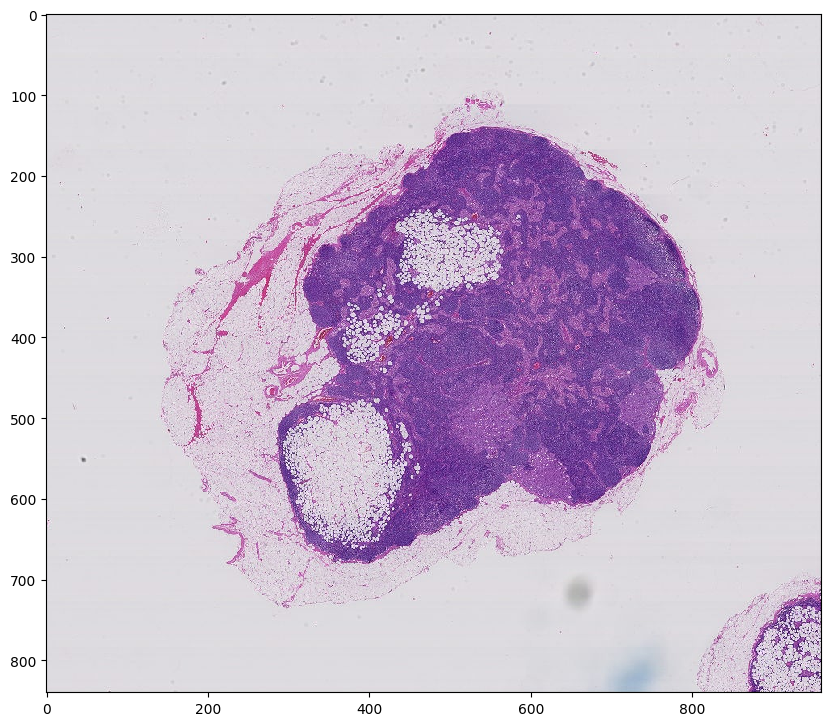

In [21]:
# Example: Reading entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=6, 
                         width=slide.level_dimensions[6][0], 
                         height=slide.level_dimensions[6][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

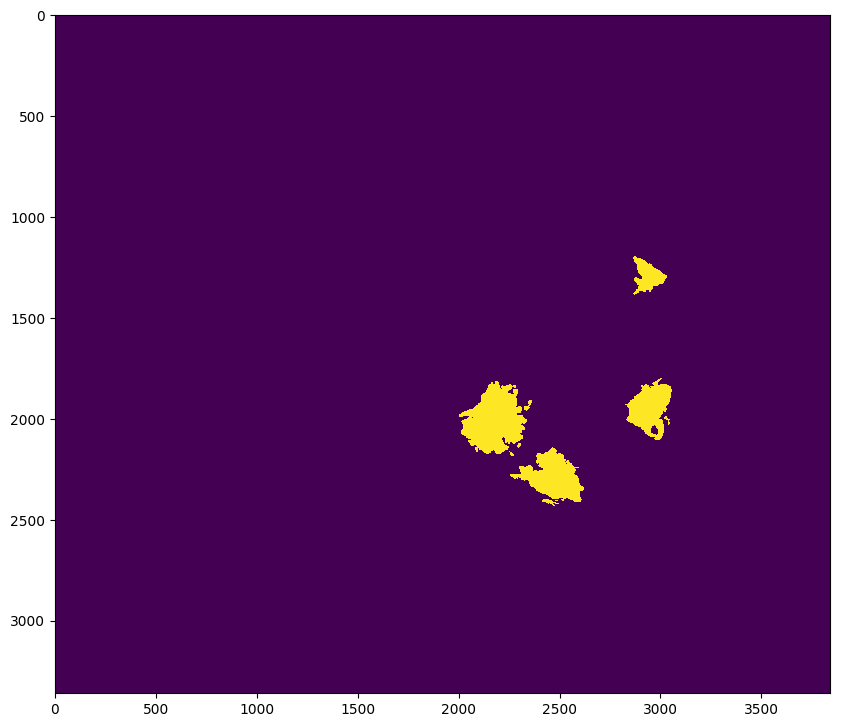

In [14]:
# Example: Reading entire mask at the same zoom level 5
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=4, 
                        width=slide.level_dimensions[4][0], 
                        height=slide.level_dimensions[4][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

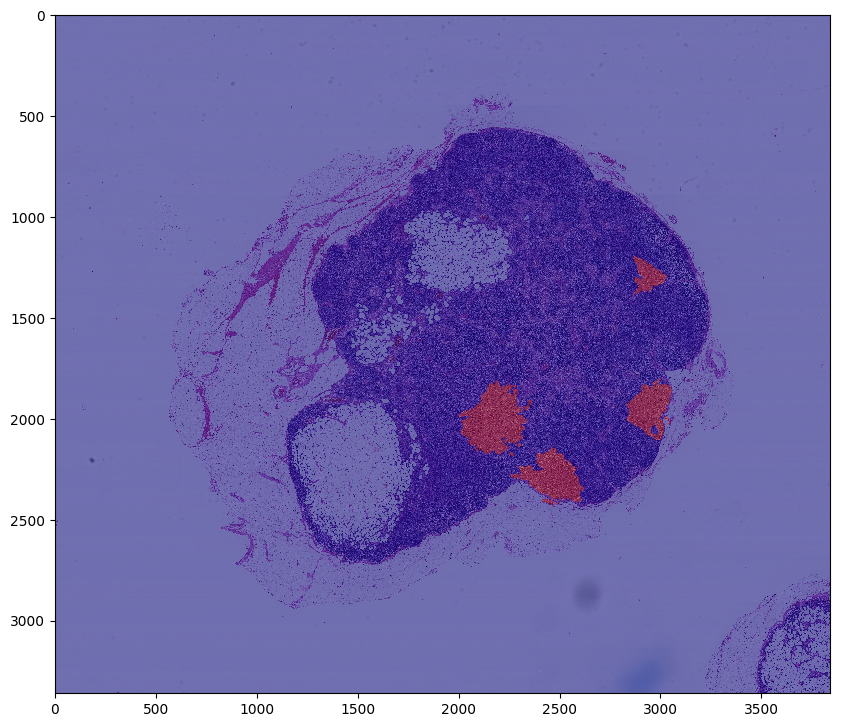

In [15]:
# Overlay the two. The mask shows the region of the slide that contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

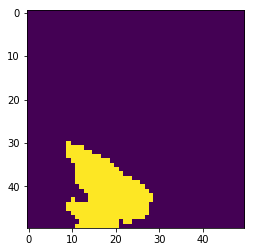

In [27]:
# Sliding window technique 

# Example: extract a patch/region from the L7 downsampled image

# How did they get the x, y coordinates?
# Note: first multiply x, y coordinates by downsample factor
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

In [28]:
# Improve efficiency by ignoring non-tissue areas of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

TypeError: ignored